三、动手实现 softmax 回归

In [74]:
#调用torch库
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
#调用numpy库
import numpy as np
#调用matplotlib库
import matplotlib.pyplot as plt
#调用random库
import random

加载Fashion-MNIST数据集（采用已经划分好的训练集和测试集）

In [2]:
mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=True, 
download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=False, 
download=True, transform=transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /home/yihanhu/Datasets/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /home/yihanhu/Datasets/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /home/yihanhu/Datasets/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /home/yihanhu/Datasets/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /home/yihanhu/Datasets/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /home/yihanhu/Datasets/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /home/yihanhu/Datasets/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /home/yihanhu/Datasets/FashionMNIST/FashionMNIST/raw



/home/yihanhu/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


题目1. 要求动手从0实现 softmax 回归（只借助Tensor和Numpy相关的库）在Fashion-MNIST数据
集上进行训练和测试，并从loss、训练集以及测试集上的准确率等多个角度对结果进行分析
（要求从零实现交叉熵损失函数）

In [126]:
#使用课上给出的数据读取函数
batch_size = 256
num_workers = 16
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True,
num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, 
num_workers=num_workers)

In [6]:
#使用课上给出的优化函数进行参数的学习优化
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

In [56]:
# 损失函数使用手动实现的交叉熵损失函数
# y_hat为模型的预测值，而y为真实标签
def Loss(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

In [55]:
# 计算预测的准确度
def accuracy(y_hat, y):  #@save
    y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [54]:
# 手动实现Softmax回归函数
class Softmax:
    def __init__(self, image_size, class_num, opt, device):
        self.w = torch.tensor(np.random.normal(0, 0.01, (image_size * image_size, class_num)), dtype=torch.float32).to(device)
        self.b = torch.zeros(class_num, dtype=torch.float32).to(device)
        self.w.requires_grad_(requires_grad=True)
        self.b.requires_grad_(requires_grad=True) 

        self.opt = opt

    def softmax(self, x):
        x_exp = torch.exp(x)
        partition = x_exp.sum(1, keepdim=True)
        return x_exp / partition

    def forward(self, x):
        x = x.squeeze(1).flatten(1, 2)
        x = torch.matmul(x, self.w) + self.b
        y_hat = self.softmax(x)
        return y_hat
    
    def learn(self, lr, bs):
        self.opt([self.w, self.b], lr, bs)

    def reset_grad(self):
        self.w.grad.data.zero_()
        self.b.grad.data.zero_()

In [68]:
epoch_num = 30
lr = 0.03
image_size = 28
class_num = 10
device = 'cuda:0'
opt = sgd
loss = Loss
net = Softmax(image_size, class_num, sgd, device)
train_loss_list = []
test_loss_list = []
test_acc_list = []
for epoch in range(epoch_num):
    for i, datas in enumerate(train_iter):
        train_x, train_label = datas[0].to(device), datas[1].to(device)
        train_pred = net.forward(train_x)
        l = loss(train_pred, train_label).sum()
        l.backward()
        net.learn(lr, batch_size)
        net.reset_grad()
        train_loss_list.append(l.item())
    
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        for i, datas in enumerate(test_iter):
            test_x, test_label = datas[0].to(device), datas[1].to(device)
            test_pred = net.forward(test_x)

            l = loss(test_pred, test_label).sum()
            total_loss += l

            acc = accuracy(test_pred, test_label) / len(test_pred)
            total_acc += acc

        test_loss_list.append(total_loss.item())
        test_acc_list.append(acc)
        print('epoch: %d, total loss: %f, total_acc: %f'%(epoch + 1, total_loss / (i+1), total_acc / (i+1)))

epoch: 0, total loss: 196.295532, total_acc: 0.744336
epoch: 1, total loss: 170.512558, total_acc: 0.779980
epoch: 2, total loss: 158.325180, total_acc: 0.791406
epoch: 3, total loss: 151.255554, total_acc: 0.798438
epoch: 4, total loss: 146.024414, total_acc: 0.809473
epoch: 5, total loss: 142.178391, total_acc: 0.814063
epoch: 6, total loss: 139.341827, total_acc: 0.816113
epoch: 7, total loss: 137.081894, total_acc: 0.815625
epoch: 8, total loss: 134.817184, total_acc: 0.820312
epoch: 9, total loss: 133.162582, total_acc: 0.821289
epoch: 10, total loss: 131.648331, total_acc: 0.822852
epoch: 11, total loss: 130.491745, total_acc: 0.824902
epoch: 12, total loss: 129.089035, total_acc: 0.826270
epoch: 13, total loss: 128.044617, total_acc: 0.829199
epoch: 14, total loss: 127.534233, total_acc: 0.827637
epoch: 15, total loss: 126.344376, total_acc: 0.829199
epoch: 16, total loss: 125.896873, total_acc: 0.829883
epoch: 17, total loss: 124.884415, total_acc: 0.830957
epoch: 18, total los

绘制训练损失图

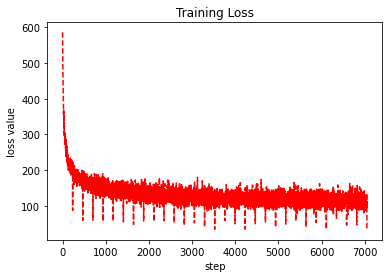

In [69]:
x = [i + 1 for i in range(len(train_loss_list))]
y = train_loss_list
l1 = plt.plot(x, y, 'r--', label='train_loss')

plt.title('Training Loss')
plt.xlabel('step')
plt.ylabel('loss value')
plt.show()

绘制验证损失图

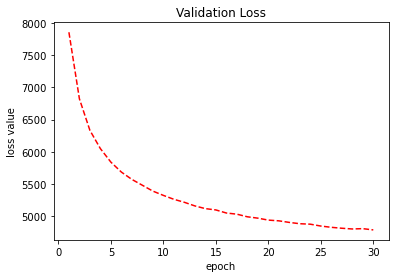

In [70]:
x = [i + 1 for i in range(len(test_loss_list))]
y = test_loss_list
l1 = plt.plot(x, y, 'r--', label='test_loss')

plt.title('Validation Loss')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()

绘制验证精度图

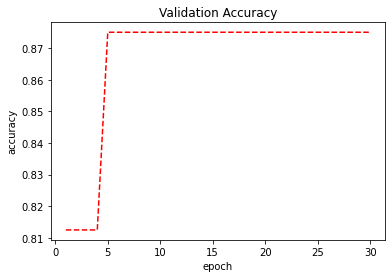

In [72]:
x = [i + 1 for i in range(len(test_acc_list))]
y = test_acc_list
l1 = plt.plot(x, y, 'r--', label='test_acc')

plt.title('Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

题目2. 利用torch.nn实现 softmax 回归在Fashion-MNIST数据集上进行训练和测试，并从loss，训
练集以及测试集上的准确率等多个角度对结果进行分析

In [170]:
class SoftmaxNet(nn.Module):
    def __init__(self, image_size, class_num):
        super(SoftmaxNet, self).__init__()
        self.linear = nn.Linear(image_size * image_size, class_num)

    def forward(self, x):
        y = self.linear(x.view(x.shape[0], -1))
        return y

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.01)
                nn.init.constant_(m.bias, val=0) 

In [172]:
image_size = 28
class_num = 10
device = 'cuda:0'
net = SoftmaxNet(image_size, class_num).to(device)
loss = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(), lr=0.1)
num_epochs = 10

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
for epoch in range(num_epochs):
    total_loss, total_acc, nums = 0.0, 0.0, 0
    for train_data, train_label in train_iter:
        train_data = train_data.to(device)
        train_label = train_label.to(device)
        train_pred = net(train_data)
        l = loss(train_pred, train_label).sum()
        train_loss_list.append(l.item())
        opt.zero_grad()
        l.backward()
        opt.step()

        total_loss += l.item()
        total_acc += (train_pred.argmax(dim=1) == train_label).sum().item()
        nums += train_label.shape[0] 

    test_acc, test_nums = 0.0, 0
    for test_data, test_label in test_iter:
        test_data = test_data.to(device)
        test_label = test_label.to(device)
        test_acc += (net(test_data).argmax(dim=1) == test_label).float().sum().item()
        test_nums += test_label.shape[0]
    test_acc = test_acc / test_nums
    test_loss_list.append(total_loss / nums)
    train_acc_list.append(total_acc / nums)
    test_acc_list.append(test_acc)
    print('epoch %d, loss %f, train acc %f, test acc %f' % (epoch + 1, total_loss / nums, total_acc / nums, test_acc))

epoch 1, loss 0.003079, train acc 0.750767, test acc 0.753500
epoch 2, loss 0.002230, train acc 0.813067, test acc 0.805100
epoch 3, loss 0.002054, train acc 0.826100, test acc 0.817200
epoch 4, loss 0.001963, train acc 0.831750, test acc 0.822500
epoch 5, loss 0.001901, train acc 0.837367, test acc 0.822700
epoch 6, loss 0.001854, train acc 0.840550, test acc 0.822200
epoch 7, loss 0.001822, train acc 0.842800, test acc 0.830300
epoch 8, loss 0.001792, train acc 0.845433, test acc 0.825700
epoch 9, loss 0.001770, train acc 0.847267, test acc 0.825000
epoch 10, loss 0.001751, train acc 0.847817, test acc 0.828700


绘制训练损失图

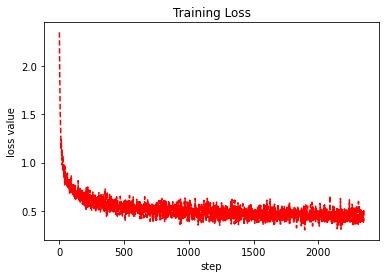

In [173]:
x = [i + 1 for i in range(len(train_loss_list))]
y = train_loss_list
l1 = plt.plot(x, y, 'r--', label='train_loss')

plt.title('Training Loss')
plt.xlabel('step')
plt.ylabel('loss value')
plt.show()

绘制训练精度图

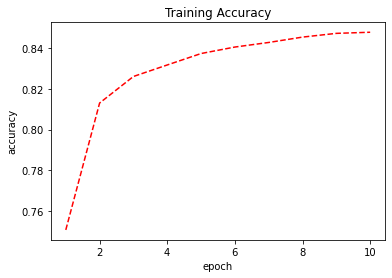

In [174]:
x = [i + 1 for i in range(len(train_acc_list))]
y = train_acc_list
l1 = plt.plot(x, y, 'r--', label='train_acc')

plt.title('Training Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

绘制验证损失图

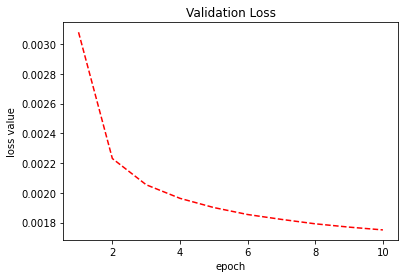

In [175]:
x = [i + 1 for i in range(len(test_loss_list))]
y = test_loss_list
l1 = plt.plot(x, y, 'r--', label='test_loss')

plt.title('Validation Loss')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()

绘制验证精度图

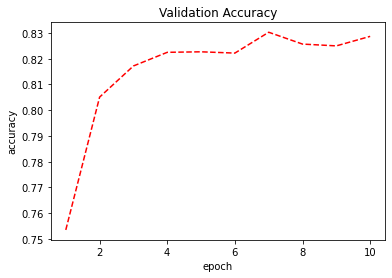

In [176]:
x = [i + 1 for i in range(len(test_acc_list))]
y = test_acc_list
l1 = plt.plot(x, y, 'r--', label='test_acc')

plt.title('Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()